# Preliminaries: Inspect and Set up environment

In [1]:
# Import all libraries required

# Data Processing and EDA
import datetime
import pandas as pd
import numpy as np

# For bioinformatics tasks
from Bio import SeqIO
# older alignment method
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
# newer alignment method
from Bio import Align
from Bio.Align import PairwiseAligner
import multiprocessing

# For Machine Learning
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# For Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from seaborn import heatmap
import matplotlib.pyplot as plt

/home/ajvilleg/miniforge3/envs/learn-flu/lib/python3.12/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [2]:
# Environment
# Show all the output for every print not just the last
from IPython.core.interactiveshell import InteractiveShell
# Configuration and settings
InteractiveShell.ast_node_interactivity = "all"
# To check if in Google Colab
from IPython.core.getipython import get_ipython
# To display all the output in a nicer table
from IPython.display import display
# To time the execution of the code
import time
import os.path

In [3]:
print(datetime.datetime.now())

2024-07-25 17:57:26.233725


In [4]:
!which python

/home/ajvilleg/miniforge3/envs/learn-flu/bin/python


In [5]:
!python --version

Python 3.12.2


In [6]:
!echo $PYTHONPATH

In [7]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [8]:
#if 'google.colab' in str(get_ipython()):
    # TODO: if running on Google Colab, install any packages you need to here. For example:
    #!pip install unidecode
    #!pip install category_encoders
    #!pip install scikeras

In [9]:
# Let's minimize randomness
# numpy
np.random.seed(42)

Start the timer

In [10]:
# Start timing the entire process
start_time = time.time()

# 1.0 Data Exploration

## 1.1 Load data

In [11]:
# Parse the FASTA file
records = list(SeqIO.parse("/home/ajvilleg/Netdrive/AI/GISAID/EpiFlu_Training/30-Jun-2024/gisaid_epiflu_sequence_2024-06-30.fasta", "fasta"))


In [12]:
# Extract the details from the description of each record
data = []

# Iterate through records for every pair for NA and HA segments
for record1, record2 in zip(records[::2], records[1::2]):
    description1 = record1.description.split('|')
    description2 = record2.description.split('|')

    # Assume the isolate name is the same for both segments
    isolate_name1 = description1[0].strip()
    isolate_name2 = description2[0].strip()
    if isolate_name1 != isolate_name2:
        print(f"Isolate names do not match: {isolate_name1} vs {isolate_name2}")
        raise ValueError("Isolate names do not match")

    # Assume the isolate ID is the same for both segments
    isolate_id1 = description1[1].strip()
    isolate_id2 = description2[1].strip()
    if isolate_id1 != isolate_id2:
        print(f"Isolate IDs do not match: {isolate_id1} vs {isolate_id2}")
        raise ValueError("Isolate IDs do not match")

    # Assume the flu type is the same for both segments
    flu_type1 = description1[2].strip()
    flu_type2 = description2[2].strip()
    if flu_type1 != flu_type2:
        print(f"Flu types do not match: {flu_type1} vs {flu_type2}")
        raise ValueError("Flu types do not match")

    # Assume the lineage is the same for both segments
    lineage1 = description1[3].strip()
    lineage2 = description2[3].strip()
    if lineage1 != lineage2:
        print(f"Lineages do not match: {lineage1} vs {lineage2}")
        raise ValueError("Lineages do not match")

    # The segment labels are different for NA and HA segments
    segment1 = description1[4].strip()
    segment2 = description2[4].strip()  

    # Assume the collection date is the same for both segments
    collection_date1 = description1[5].strip()
    collection_date2 = description2[5].strip()
    if collection_date1 != collection_date2:
        print(f"Collection dates do not match: {collection_date1} vs {collection_date2}")
        raise ValueError("Collection dates do not match")

    # Assume the clade is the same for both segments. This is important as this will be our label for classification
    clade1 = description1[6].strip()
    clade2 = description2[6].strip()
    if clade1 != clade2:
        print(f"Clades do not match: {clade1} vs {clade2}")
        raise ValueError("Clades do not match")

    # The sequences will be different corresopnding to the NA and HA segments
    sequence1 = str(record1.seq)
    sequence2 = str(record2.seq)
    if segment1 == 'HA':
        sequence_ha = sequence1
        sequence_na = sequence2
    else: # segment2 == 'HA'
        sequence_ha = sequence2
        sequence_na = sequence1
    data.append([isolate_name1, isolate_id1, flu_type1, lineage1, sequence_ha, sequence_na, collection_date1, clade1])

df = pd.DataFrame(data, columns=['Isolate_Name', 'Isolate_ID', 'Flu_Type', 'Lineage', 'HA', 'NA', 'Collection Date', 'Clade'])


In [13]:
# Take a look at the data  
display(df)

,Isolate_Name,Isolate_ID,Flu_Type,Lineage,HA,NA,Collection Date,Clade
0,A/Michigan/136/2018,EPI_ISL_360559,A_/_H1N1,pdm09,ggaaaacaaaagcaacaaaaatgaaggcaatactagtagttctgct...,agtttaaaatgaatccaaaccaaaagataataaccattggttcgat...,2018-01-16,6B.1A
1,A/USA/7C9/2010,EPI_ISL_17760636,A_/_H1N1,pdm09,atgaaggcaatactagtagttctgctatatacatttgcaaccgcaa...,atgaatccaaaccaaaagataataaccattggttcgatctgtatga...,2010-11-01,6B.1
2,A/USA/7C7/2010,EPI_ISL_17760635,A_/_H1N1,pdm09,atgaaggcaatactagtagttctgctatatacatttgcaaccgcaa...,atgaatccaaaccaaaagataataaccattggttcgatctgtatga...,2010-11-01,6B.1
3,A/USA/7K3/1935,EPI_ISL_17760634,A_/_H1N1,pdm09,atgaaggcaatactagtagttctgctatatacatttgcaaccgcaa...,atgaatccaaaccaaaagataataaccattggttcggtctgtatga...,2010-11-01,6B.1
4,A/Michigan/98/2018,EPI_ISL_360571,A_/_H1N1,pdm09,ggaaaacaaaagcaacaaaaatgaaggcaatactagtagttctgct...,agtttaaaatgaatccaaaccaaaagataataaccattggttcgat...,2018-01-08,6B.1A
...,...,...,...,...,...,...,...,...
15414,A/Washington/97/2020,EPI_ISL_2588628,A_/_H1N1,pdm09,ggaaaacaaaagcaacaaaaatgaaggcaatactagtagttatgct...,agtttaaaatgaatccaaaccaaaagataataaccattggttctat...,2020-02-04,6B.1A.5a.2
15415,A/Washington/96/2020,EPI_ISL_2588627,A_/_H1N1,pdm09,ggaaaacaaaagcaacaaaaatgaaggcaatactagtagttatgct...,agtttaaaatgaatccaaaccaaaagataataaccattggttctat...,2020-02-04,6B.1A.5a.2
15416,A/Washington/90/2020,EPI_ISL_2588626,A_/_H1N1,pdm09,ggaaaacaaaagcaacaaaaatgaaggcaatactagtagttctgct...,agtttaaaatgaatccaaaccaaaagataataaccattggctctat...,2020-02-02,6B.1A.5a.1
15417,A/Pennsylvania/164/2020,EPI_ISL_2588633,A_/_H1N1,pdm09,ggaaaacaaaagcaacaaaaatgaaggcaatactagtagttatgct...,agtttaaaatgaatccaaaccaaaagataataaccattggttctat...,2020-02-24,6B.1A.5a.2


## 1.2 EDA

### 1.2.1 Dataframe structure

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15419 entries, 0 to 15418
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Isolate_Name     15419 non-null  object
 1   Isolate_ID       15419 non-null  object
 2   Flu_Type         15419 non-null  object
 3   Lineage          15419 non-null  object
 4   HA               15419 non-null  object
 5   NA               15419 non-null  object
 6   Collection Date  15419 non-null  object
 7   Clade            15419 non-null  object
dtypes: object(8)
memory usage: 963.8+ KB


In [15]:
# Convert all columns to strings except Collection Date
df = df.astype(str)

# Convert "Collection Date" column to date
df["Collection Date"] = pd.to_datetime(df["Collection Date"])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15419 entries, 0 to 15418
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Isolate_Name     15419 non-null  object        
 1   Isolate_ID       15419 non-null  object        
 2   Flu_Type         15419 non-null  object        
 3   Lineage          15419 non-null  object        
 4   HA               15419 non-null  object        
 5   NA               15419 non-null  object        
 6   Collection Date  15419 non-null  datetime64[ns]
 7   Clade            15419 non-null  object        
dtypes: datetime64[ns](1), object(7)
memory usage: 963.8+ KB


### 1.2.2 Describe

In [16]:
df.describe()

,Collection Date
count,15419
mean,2017-12-03 02:55:00.914456320
min,2009-01-01 00:00:00
25%,2016-03-03 00:00:00
50%,2019-01-23 00:00:00
75%,2020-01-22 00:00:00
max,2023-04-26 00:00:00


### 1.2.3 Duplicated rows

In [17]:
# Check for duplicated rows in training data
print(f'df has {df.duplicated().sum()} duplicate rows')
display(df[df.duplicated()])
# Drop duplicates and check again
df.drop_duplicates(inplace=True)
print(f'df has {df.duplicated().sum()} duplicate rows')

df has 1 duplicate rows


,Isolate_Name,Isolate_ID,Flu_Type,Lineage,HA,NA,Collection Date,Clade
14162,A/Houston/2OS/2009,EPI_ISL_63939,A_/_H1N1,pdm09,aaaagcaacaaaaatgaaggcaatactagtagttctgctatataca...,aaatgaatccaaaccaaaagataataaccattggttcggtctgtat...,2009-05-18,6B.1


df has 0 duplicate rows


### 1.2.4 Missing values / NaN / Empty Strings

In [18]:
# Check for missing values and empty strings
print("Missing values in df:")
print(df.isnull().sum())  # Check for NaN values
print("\nEmpty string values in df:")
for col in df.select_dtypes(include=['object']):  # Iterate over columns with string datatype
    print(f"{col}: {(df[col] == '').sum()}")     # Count empty strings

Missing values in df:
Isolate_Name       0
Isolate_ID         0
Flu_Type           0
Lineage            0
HA                 0
NA                 0
Collection Date    0
Clade              0
dtype: int64

Empty string values in df:
Isolate_Name: 0
Isolate_ID: 0
Flu_Type: 0
Lineage: 0
HA: 0
NA: 0
Clade: 0


In [19]:
# Drop rows with nulls in the training data
df.dropna(inplace=True) # Drop rows with NaN values

In [20]:
# Drop rows with empty strings in the training data

# Create mask for rows with empty strings
train_mask = (df == '').any(axis=1)

# Invert mask to select rows without empty strings
df = df[~train_mask]

In [21]:
# Check for missing values and empty strings
print("Missing values in df:")
print(df.isnull().sum())  # Check for NaN values
print("\nEmpty string values in df:")
for col in df.select_dtypes(include=['object']):  # Iterate over columns with string datatype
    print(f"{col}: {(df[col] == '').sum()}")     # Count empty strings

Missing values in df:
Isolate_Name       0
Isolate_ID         0
Flu_Type           0
Lineage            0
HA                 0
NA                 0
Collection Date    0
Clade              0
dtype: int64

Empty string values in df:
Isolate_Name: 0
Isolate_ID: 0
Flu_Type: 0
Lineage: 0
HA: 0
NA: 0
Clade: 0


### 1.2.5 Class imbalance in Clade column

In [22]:
df['Clade'].value_counts()

Clade
6B.1             4862
6B.1A.5a.2a.1    1914
6B.1A.1          1576
6B.1A.5a.1       1538
6B.1A.5b         1304
6B.1A.5a.2       1152
6B.1A.5a          922
6B.1A             590
6B.1A.7           510
6B.1A.5a.2a       373
6B.1A.6           300
6B.1A.3           206
6B.1A.2            82
6B.2               44
6B.1A.5            39
unassigned          6
Name: count, dtype: int64

In [23]:
# Drop rows with "unassigned" in 'Clade' from the training data
df = df[df['Clade'] != 'unassigned']  # Filter out rows with label "unassigned"

In [24]:
df['Clade'].value_counts()

Clade
6B.1             4862
6B.1A.5a.2a.1    1914
6B.1A.1          1576
6B.1A.5a.1       1538
6B.1A.5b         1304
6B.1A.5a.2       1152
6B.1A.5a          922
6B.1A             590
6B.1A.7           510
6B.1A.5a.2a       373
6B.1A.6           300
6B.1A.3           206
6B.1A.2            82
6B.2               44
6B.1A.5            39
Name: count, dtype: int64

### 1.2.6 Shape

In [25]:
df.shape

(15412, 8)

### 1.2.7 Look at sequence length stats

In [26]:
def get_sequence_length(row, column):
    """Calculates the length of the sequence in the specified column."""
    return len(row[column])

ha_sequence_lengths = df.apply(get_sequence_length, axis=1, column="HA")
na_sequence_lengths = df.apply(get_sequence_length, axis=1, column="NA")
print("Sequence lengths in HA columns:")
ha_sequence_lengths.describe()
print("Sequence lengths in NA columns:")
na_sequence_lengths.describe()


Sequence lengths in HA columns:


count    15412.000000
mean      1741.636452
std         22.450589
min       1410.000000
25%       1734.000000
50%       1752.000000
75%       1752.000000
max       1922.000000
dtype: float64

Sequence lengths in NA columns:


count    15412.000000
mean      1428.921555
std         12.396946
min       1410.000000
25%       1420.000000
50%       1433.000000
75%       1433.000000
max       1701.000000
dtype: float64

### 1.2.8 Extract HA1 Region

In [27]:
# Define the start strings for HA1 and HA2 regions
ha1_start = "ATGAAGGCAATACTAGTAGTTATGCTGTATACATTTACAACCGCAAATGCA"
ha2_start = "GGCCTATTCGGGGCCATTGCTGGCTTCATCGAAGGGGGGTGGACA"

In [28]:
# Using pairwise2.align.localmst - the older method
def extract_ha1_with_alignment(ha_sequence):
    # Align with HA1 start
    ha1_alignments = pairwise2.align.localms(ha1_start.lower(), ha_sequence, 2, -1, -0.5, -0.1)
    if ha1_alignments:
        best_ha1_alignment = ha1_alignments[0]  # Get the best alignment
        ha1_start_index = best_ha1_alignment[3] + len(ha1_start)  # Start after alignment

        # Align with HA2 start
        ha2_alignments = pairwise2.align.localms(ha2_start.lower(), ha_sequence, 2, -1, -0.5, -0.1)
        if ha2_alignments:
            best_ha2_alignment = ha2_alignments[0]
            ha2_start_index = best_ha2_alignment[3]  # Exact match start
            
            ha1_sequence = ha_sequence[ha1_start_index:ha2_start_index]
            return ha1_sequence
        else:
            return "ERROR: HA2 region not found in alignment"  # Or handle differently
    else:
        return "ERROR: HA1 region not found in alignment"

In [29]:
# # Using PairwiseAligner - the newer method, doesn't work
# def extract_ha1_with_alignment(ha_sequence):
#     aligner = PairwiseAligner()

#     # Configure aligner for local alignment and scoring
#     aligner.mode = 'local'
#     aligner.match_score = 2
#     aligner.mismatch_score = -1
#     aligner.open_gap_score = -5   # Adjust gap penalties as needed
#     aligner.extend_gap_score = -1

#     # Align with HA1 start
#     ha1_alignments = aligner.align(ha1_start.lower(), ha_sequence)

#     if not ha1_alignments:
#         # Try alternative extraction based on HA2 start
#         ha2_start_index = ha_sequence.find(ha2_start)
#         if ha2_start_index != -1:  # HA2 start found
#             ha1_sequence = ha_sequence[:ha2_start_index]
#             return ha1_sequence
#         else:
#             return "ERROR: Neither HA1 nor HA2 start found"  

#     for alignment in ha1_alignments:  # Iterate over possible alignments
#         ha1_start_index = alignment.aligned[0][1][0]  # Extract aligned region start
#         ha1_end_index = alignment.aligned[0][1][1]    # Extract aligned region end
        
#         # Align with HA2 start (starting from the end of the HA1 alignment)
#         ha2_alignments = aligner.align(ha2_start.lower(), ha_sequence[ha1_end_index:])
#         for alignment in ha2_alignments:
#             ha2_start_index = ha1_end_index + alignment.aligned[0][1][0]
#             ha1_sequence = ha_sequence[ha1_start_index:ha2_start_index]
#             return ha1_sequence
        
#     return "ERROR: HA1 or HA2 region not found in alignment"  

In [30]:
# Function to apply alignment in parallel
def parallel_extract_ha1(ha_sequences):
    with multiprocessing.Pool() as pool:
        return pool.map(extract_ha1_with_alignment, ha_sequences)

In [31]:
# Define the data file name that we will use 
# to save the extracted HA1 sequences so we can 
# just reload them later instead of rerunning the extraction which takes time
data_file = "train_flu_data_with_ha1_for_clade_prediction.csv"

In [32]:
# Check if the data file exists
if os.path.isfile(data_file):
    print(f"Loading pre-processed data from {data_file}")
    df = pd.read_csv(data_file)
else:
    print("Pre-processed data saved to external file not found. Performing sequence alignment and extraction...")
    # Single-threaded
    # Apply to your DataFrame
    # df['HA1'] = df['HA'].astype(str).apply(extract_ha1_with_alignment)

    # Multi-threaded
    # Apply the function in parallel (assuming your DataFrame is named 'df')
    df['HA1'] = parallel_extract_ha1(df['HA'].astype(str).tolist())

    # Show a sample alignment of the first HA sequence
    print("\n### Sample Alignment of the First HA Sequence:\n") 
    first_alignment = pairwise2.align.localms(ha1_start.lower(), df['HA'][0], 2, -1, -0.5, -0.1)[0]
    print(format_alignment(*first_alignment))

    # # Add HA1 Length Column
    # df['HA1_length'] = df['HA1'].astype(str).apply(len)

    # # Sort by HA1 Length
    # df_sorted = df.sort_values(by='HA1_length')  # Sort in ascending order

    # Save the processed data
    print("Save the processed data to external file to speed up future runs.")
    df.to_csv(data_file, index=False)


Loading pre-processed data from train_flu_data_with_ha1_for_clade_prediction.csv


In [33]:
# Print the modified DataFrame
df

,Isolate_Name,Isolate_ID,Flu_Type,Lineage,HA,NA,Collection Date,Clade,HA1
0,A/Michigan/136/2018,EPI_ISL_360559,A_/_H1N1,pdm09,ggaaaacaaaagcaacaaaaatgaaggcaatactagtagttctgct...,agtttaaaatgaatccaaaccaaaagataataaccattggttcgat...,2018-01-16,6B.1A,gacacattatgtataggttatcatgcgaacaattcaacagacactg...
1,A/USA/7C9/2010,EPI_ISL_17760636,A_/_H1N1,pdm09,atgaaggcaatactagtagttctgctatatacatttgcaaccgcaa...,atgaatccaaaccaaaagataataaccattggttcgatctgtatga...,2010-11-01,6B.1,gacacattatgtataggttatcatgcgaacaattcaacagacactg...
2,A/USA/7C7/2010,EPI_ISL_17760635,A_/_H1N1,pdm09,atgaaggcaatactagtagttctgctatatacatttgcaaccgcaa...,atgaatccaaaccaaaagataataaccattggttcgatctgtatga...,2010-11-01,6B.1,gacacattatgtataggttatcatgcgaacaattcaacagacactg...
3,A/USA/7K3/1935,EPI_ISL_17760634,A_/_H1N1,pdm09,atgaaggcaatactagtagttctgctatatacatttgcaaccgcaa...,atgaatccaaaccaaaagataataaccattggttcggtctgtatga...,2010-11-01,6B.1,gacacattatgtataggttatcatgcgaacaattcaacagacactg...
4,A/Michigan/98/2018,EPI_ISL_360571,A_/_H1N1,pdm09,ggaaaacaaaagcaacaaaaatgaaggcaatactagtagttctgct...,agtttaaaatgaatccaaaccaaaagataataaccattggttcgat...,2018-01-08,6B.1A,gacacattatgtataggttatcatgcgaacaattcaacagacactg...
...,...,...,...,...,...,...,...,...,...
15407,A/Washington/97/2020,EPI_ISL_2588628,A_/_H1N1,pdm09,ggaaaacaaaagcaacaaaaatgaaggcaatactagtagttatgct...,agtttaaaatgaatccaaaccaaaagataataaccattggttctat...,2020-02-04,6B.1A.5a.2,gacacattatgtataggttatcatgcgaacaattcaacagacactg...
15408,A/Washington/96/2020,EPI_ISL_2588627,A_/_H1N1,pdm09,ggaaaacaaaagcaacaaaaatgaaggcaatactagtagttatgct...,agtttaaaatgaatccaaaccaaaagataataaccattggttctat...,2020-02-04,6B.1A.5a.2,gacacattatgtataggttatcatgcgaacaattcaacagacactg...
15409,A/Washington/90/2020,EPI_ISL_2588626,A_/_H1N1,pdm09,ggaaaacaaaagcaacaaaaatgaaggcaatactagtagttctgct...,agtttaaaatgaatccaaaccaaaagataataaccattggctctat...,2020-02-02,6B.1A.5a.1,gacacattatgtataggttatcatgcgaacaattcaacagacactg...
15410,A/Pennsylvania/164/2020,EPI_ISL_2588633,A_/_H1N1,pdm09,ggaaaacaaaagcaacaaaaatgaaggcaatactagtagttatgct...,agtttaaaatgaatccaaaccaaaagataataaccattggttctat...,2020-02-24,6B.1A.5a.2,gacacattatgtataggttatcatgcgaacaattcaacagacactg...


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15412 entries, 0 to 15411
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Isolate_Name     15412 non-null  object
 1   Isolate_ID       15412 non-null  object
 2   Flu_Type         15412 non-null  object
 3   Lineage          15412 non-null  object
 4   HA               15412 non-null  object
 5   NA               15412 non-null  object
 6   Collection Date  15412 non-null  object
 7   Clade            15412 non-null  object
 8   HA1              15410 non-null  object
dtypes: object(9)
memory usage: 1.1+ MB


#### Drop any empty HA1 subregions

In [35]:
df.shape

(15412, 9)

In [36]:
# Drop rows with empty strings in 'HA1' from the training data
# This step only works when the extraction is run, not when loading the saved extraction file
df = df[(df['HA1'] != '')]
df.shape

(15412, 9)

In [37]:
# Drop rows with NaN in 'HA1' from the training data
# This step only works when loading the saved extraction file, not when running the extraction
# Excel adds NaN values when saving empty strings
df.dropna(subset=['HA1'], inplace=True)  # Drop rows with NaN (including empty strings)
df.shape

(15410, 9)

In [38]:
ha1_sequence_lengths = df.apply(get_sequence_length, axis=1, column="HA1")
print("Sequence lengths in HA1 columns:")
ha1_sequence_lengths.describe()

Sequence lengths in HA1 columns:


count    15410.000000
mean       980.796820
std          3.101824
min        900.000000
25%        981.000000
50%        981.000000
75%        981.000000
max        981.000000
dtype: float64

#### Drop rows where HA1 subregion < 981

In [39]:
df = df[ha1_sequence_lengths >= 981]

In [40]:
df.shape

(15323, 9)

In [41]:
ha1_sequence_lengths = df.apply(get_sequence_length, axis=1, column="HA1")
print("Sequence lengths in HA1 columns:")
ha1_sequence_lengths.describe()

Sequence lengths in HA1 columns:


count    15323.0
mean       981.0
std          0.0
min        981.0
25%        981.0
50%        981.0
75%        981.0
max        981.0
dtype: float64

# 2.0 Data Preparation

### 2.1 K-mers and k-mer encoding

In [42]:
# Define k-mer length
# kmer_length = 12
kmer_length = 6

In [43]:
# Function to extract kmers (can be reused)
def get_kmers(sequence, k):
  """
  Extracts all k-mers (subsequences of length k) from a DNA sequence.
  """
  kmers = []
  for i in range(len(sequence) - k + 1):
    kmer = sequence[i:i+k]
    kmers.append(kmer)
  return kmers

In [44]:
# Create an empty dictionary to store kmers for each sequence (identified by row index)
kmer_dict = {}

In [45]:
# Extract k-mers with length kmer_length from each sequence and store them in the dictionary
for i, row in df.iterrows():
  # Extract kmers from HA sequence (assuming it exists)
  ha1_kmers = []
  # ha_kmers = []
  if "HA1" in row:  # Check if "HA1" column exists
  # if "HA" in row:  # Check if "HA" column exists
    # sequence = str(row["HA"])
    # ha_kmers = get_kmers(sequence, kmer_length)
    sequence = str(row["HA1"])
    ha1_kmers = get_kmers(sequence, kmer_length)

  # # Extract kmers from NA sequence (assuming it exists)
  # na_kmers = []
  # if "NA" in row:  # Check if "NA" column exists
  #   sequence = str(row["NA"])
  #   na_kmers = get_kmers(sequence, kmer_length)

  # Store kmers separately in the dictionary
  kmer_dict[i] = {
    "HA1": ha1_kmers
      # "HA": ha_kmers,
      # "NA": na_kmers,
  }

In [46]:
df.loc[1, "HA1"]


'gacacattatgtataggttatcatgcgaacaattcaacagacactgtagacacagtactagaaaagaatgtaacagtaacacactctgttaaccttctagaagacaagcataacgggaaactatgcaaactaagaggggtagccccattgcatttgggtaaatgtaacattgctggctggatcctgggaaatccagagtgtgaatcactctccacagcaagctcatggtcctacattgtggaaacatctagttcagacaatggaacgtgttacccaggagatttcatcaattatgaggagctaagagagcaattgagctcagtgtcatcatttgaaaggtttgagatattccccaagacaagttcatggcccaatcatgactcgaacaaaggtgtaacggcagcatgtcctcatgctggagcaaaaagcttctacaaaaatttaatatggctagttaaaaaaggaaattcatacccaaagctcagcaaatcctacattaatgataaagggaaagaagtcctcgtgctatggggcattcaccatccatctactactgctgaccaacaaagtctctatcagaatgcagatgcatatgtttttgtggggacatcaagatacagcaagaagttcaagccggaaatagcaataagacccaaagtgagggatcaagaagggagaatgaactattactggacactagtagagccgggagacaaaataacattcgaagcaactggaaatctagtggtaccgagatatgcattcgcaatggaaagaaatgctggatctggtattatcatttcagatacaccagtccacgattgcaatacaacttgtcagacacccaagggtgctataaacaccagcctcccatttcagaatatacatccgatcacaattggaaaatgtccaaaatatgtaaaaagcacaaaattgaggctggccacaggattgaggaatgtcccgtctattcaatctaga'

In [47]:
row_index = 1  # Replace with the desired row index
kmer_breakdown = kmer_dict[row_index]
print(kmer_breakdown)

{'HA1': ['gacaca', 'acacat', 'cacatt', 'acatta', 'cattat', 'attatg', 'ttatgt', 'tatgta', 'atgtat', 'tgtata', 'gtatag', 'tatagg', 'ataggt', 'taggtt', 'aggtta', 'ggttat', 'gttatc', 'ttatca', 'tatcat', 'atcatg', 'tcatgc', 'catgcg', 'atgcga', 'tgcgaa', 'gcgaac', 'cgaaca', 'gaacaa', 'aacaat', 'acaatt', 'caattc', 'aattca', 'attcaa', 'ttcaac', 'tcaaca', 'caacag', 'aacaga', 'acagac', 'cagaca', 'agacac', 'gacact', 'acactg', 'cactgt', 'actgta', 'ctgtag', 'tgtaga', 'gtagac', 'tagaca', 'agacac', 'gacaca', 'acacag', 'cacagt', 'acagta', 'cagtac', 'agtact', 'gtacta', 'tactag', 'actaga', 'ctagaa', 'tagaaa', 'agaaaa', 'gaaaag', 'aaaaga', 'aaagaa', 'aagaat', 'agaatg', 'gaatgt', 'aatgta', 'atgtaa', 'tgtaac', 'gtaaca', 'taacag', 'aacagt', 'acagta', 'cagtaa', 'agtaac', 'gtaaca', 'taacac', 'aacaca', 'acacac', 'cacact', 'acactc', 'cactct', 'actctg', 'ctctgt', 'tctgtt', 'ctgtta', 'tgttaa', 'gttaac', 'ttaacc', 'taacct', 'aacctt', 'accttc', 'ccttct', 'cttcta', 'ttctag', 'tctaga', 'ctagaa', 'tagaag', 'agaaga', '

#### 2.1.1 Count-based Encoding using chunking to optimize memory usage

In [48]:
# Define chunk size (adjust as needed)
chunk_size = 100

In [49]:
# def process_chunk(chunk_dict):
#     # """
#     # Processes a chunk of data from the kmer_dict and returns count-based features,
#     # keeping HA and NA k-mer counts separate to avoid overlap issues.
#     # """
#     """
#     Processes a chunk of data from the kmer_dict and returns count-based features,
#     keeping HA1 k-mer counts.
#     """
#     chunk_ha1_features = []
#     # chunk_ha_features, chunk_na_features = [], []

#     for kmer_dict_row in chunk_dict.values():
#         # Extract HA and NA kmers
#         # ha_kmers = kmer_dict_row["HA"]
#         # na_kmers = kmer_dict_row["NA"]
#         # Extract HA1 kmers
#         ha1_kmers = kmer_dict_row["HA1"]

#         # # Count occurrences of kmers for HA and NA separately
#         # ha_kmer_counts = Counter(ha_kmers)
#         # na_kmer_counts = Counter(na_kmers)
#         # Count occurerences of kmers for HA1
#         ha1_kmer_counts = Counter(ha1_kmers)

#         # Extract counts and append as features (ensure consistent order for all chunks)
#         # all_kmers = list(set(ha_kmer_counts.keys()) | set(na_kmer_counts.keys()))  # Get unique k-mers
#         all_kmers = list(ha1_kmer_counts.keys())

#         # chunk_ha_features.append([ha_kmer_counts[kmer] if kmer in ha_kmer_counts else 0 for kmer in all_kmers])
#         # chunk_na_features.append([na_kmer_counts[kmer] if kmer in na_kmer_counts else 0 for kmer in all_kmers])
#         chunk_ha1_features.append([ha1_kmer_counts[kmer] if kmer in ha1_kmer_counts else 0 for kmer in all_kmers])
#         # END New code tweak

#     # return chunk_ha_features, chunk_na_features
#     return chunk_ha1_features

#### 2.1.1 One-Hot Encoding using chunking to optimize memory usage

In [50]:
def process_chunk(chunk_dict):
    """
    Processes a chunk of data from the kmer_dict and returns one-hot encoded features.
    """
    chunk_ha1_features = []

    # Get unique k-mers across all sequences in the chunk
    # Only run this code if 'ohe' attribute does not exist. This is to ensure that the one-hot encoder is only fit once.
    # So, for the test data, 'ohe' already defined, this code will not run (will not do a fit on a new OHE) and go directly to the transformation step below
    if not hasattr(process_chunk, 'ohe'):
        all_kmers = set()
        for kmer_dict_row in chunk_dict.values():
            ha1_kmers = kmer_dict_row["HA1"]
            all_kmers.update(ha1_kmers)

        # Create one-hot encoder (only fit on the first chunk for consistent categories)
        process_chunk.ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        process_chunk.ohe.fit([[kmer] for kmer in list(all_kmers)])  # Fit on unique kmers

    # Transform each sequence into a one-hot encoded vector
    for kmer_dict_row in chunk_dict.values():
        ha1_kmers = kmer_dict_row["HA1"]
        kmer_indices = process_chunk.ohe.transform([[kmer] for kmer in ha1_kmers]).sum(axis=0)
        chunk_ha1_features.append(kmer_indices)

    return chunk_ha1_features

In [51]:
# # Original code
# # Iterate through kmer_dict in chunks
# ha_features = []
# na_features = []
# for i in range(0, len(kmer_dict), chunk_size):
#   # Get a chunk of data
#   chunk_dict = dict(list(kmer_dict.items())[i:i + chunk_size])

#   # Process features for the chunk
#   chunk_ha_features, chunk_na_features = process_chunk(chunk_dict)

#   # Append features from the chunk
#   ha_features.extend(chunk_ha_features)
#   na_features.extend(chunk_na_features)

In [52]:
# Iterate through kmer_dict in chunks
ha1_features = []
for i in range(0, len(kmer_dict), chunk_size):
  # Get a chunk of data
  chunk_dict = dict(list(kmer_dict.items())[i:i + chunk_size])

  # Process features for the chunk
  chunk_ha1_features = process_chunk(chunk_dict)

  # Append features from the chunk
  ha1_features.extend(chunk_ha1_features)

### 2.3 Define X and y and Train Test Split

In [53]:
# # Original code
# X = []

# # Assuming ha_features and na_features contain lists
# ha_features = [np.array(l) for l in ha_features]  # Convert lists to arrays
# na_features = [np.array(l) for l in na_features]  # Convert lists to arrays

# # The arrays in ha_features and na_features have different shapes, we need to ensure that the arrays in ha_features and na_features have the same shape before concatenating them.

In [54]:
# # CBE
# X = []

# # Assuming ha1_features contains lists
# ha1_features = [np.array(l) for l in ha1_features]  # Convert lists to arrays

In [55]:
# # Original code
# # Pad shorter arrays in ha_features and na_features with zeros
# # Find the maximum number of features across all arrays
# max_feature_count = max(arr.shape[0] for arr in ha_features + na_features)

# # Pad shorter arrays in ha_features and na_features with zeros
# for i in range(len(ha_features)):
#   ha_features[i] = np.pad(ha_features[i], (0, max_feature_count - len(ha_features[i])), mode='constant')

# for i in range(len(na_features)):
#   na_features[i] = np.pad(na_features[i], (0, max_feature_count - len(na_features[i])), mode='constant')

# # Now concatenate by sample/instance (axis=1, instead of axis=0 which is stacking on top of each other) the padded arrays (assuming na_features have consistent shapes)
# X = np.concatenate((ha_features, na_features), axis=1)

In [56]:
# # CBE
# # Pad shorter arrays in ha1_features zeros
# # Find the maximum number of features across all arrays
# max_feature_count = max(arr.shape[0] for arr in ha1_features)

# # Pad shorter arrays in ha1_features with zeros
# for i in range(len(ha1_features)):
#   ha1_features[i] = np.pad(ha1_features[i], (0, max_feature_count - len(ha1_features[i])), mode='constant')

# X = ha1_features

In [57]:
# # CBE
# max_feature_count

In [58]:
# OHE
# Convert list of lists to numpy array for X (training data)
X = np.array(ha1_features)

In [59]:
y = []
le = LabelEncoder()

# Fit the LabelEncoder to all unique classes (call only once)
le.fit(df['Clade'])

for index in df.index:
  clade_label = le.transform(np.array([df.loc[index, "Clade"]]))[0]
  y.append(clade_label)

LabelEncoder()

In [60]:
# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Set random_state for reproducibility

# 3.0 Modelling

In [61]:
# # Train a Logistic Regression model
# model = LogisticRegression(multi_class='ovr', solver='lbfgs')
# model.fit(X_train, y_train)

In [62]:
# Train a Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust hyperparameters
model.fit(X_train, y_train) 

RandomForestClassifier(random_state=42)

In [63]:
# # Train a Random Forest model with balanced class weights to handle class imbalance
# model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced') 
# model.fit(X_train, y_train) 

# 4.0 Validation

In [64]:
# Make predictions on the testing set
y_pred = model.predict(X_test)

In [65]:
# Evaluate Predictions
print("\n### Model Evaluation on Train/Validation Dataset ###")

# Accuracy: Proportion of correctly predicted samples
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Precision: Ratio of true positives to all predicted positives
precision = precision_score(y_test, y_pred, average='weighted') # Weighted average for multi-class
print("Precision:", precision)

# Recall: Ratio of true positives to all actual positives
recall = recall_score(y_test, y_pred, average='weighted')  # Weighted average for multi-class
print("Recall:", recall)

# F1-score: Harmonic mean of precision and recall
f1 = f1_score(y_test, y_pred, average='weighted')  # Weighted average for multi-class
print("F1-score:", f1)


### Model Evaluation on Train/Validation Dataset ###
Accuracy: 0.9960848287112561
Precision: 0.9960971451990488
Recall: 0.9960848287112561
F1-score: 0.9960775576762622


### Classification Report

In [66]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       972
           1       0.98      0.98      0.98       120
           2       1.00      1.00      1.00       292
           3       0.95      0.95      0.95        20
           4       0.95      0.90      0.93        41
           5       1.00      1.00      1.00         9
           6       1.00      1.00      1.00       204
           7       1.00      1.00      1.00       346
           8       1.00      1.00      1.00       248
           9       1.00      1.00      1.00        67
          10       1.00      1.00      1.00       354
          11       1.00      1.00      1.00       229
          12       0.93      0.96      0.95        56
          13       1.00      1.00      1.00        97
          14       0.90      0.90      0.90        10

    accuracy                           1.00      3065
   macro avg       0.98      0.98      0.98      3065
we

### Confusion Matrix


Confusion Matrix:


<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 36.72222222222221, 'Predicted Clade')

Text(70.72222222222221, 0.5, 'True Clade')

Text(0.5, 1.0, 'Confusion Matrix')

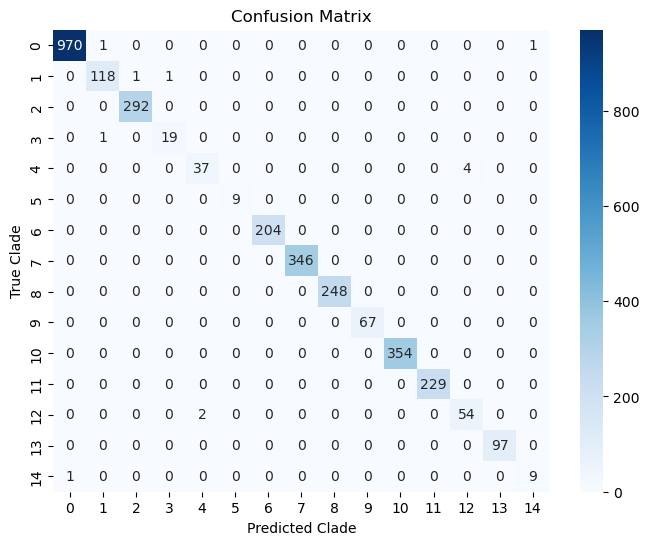

In [67]:
# Confusion Matrix with Seaborn
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)

# Create a new figure for the confusion matrix
plt.figure(figsize=(8, 6))

# Create heatmap using seaborn
heatmap(cm, annot=True, fmt="d", cmap="Blues") # Customize heatmap with annotations, format, and colormap

# Add labels and title
plt.xlabel("Predicted Clade")
plt.ylabel("True Clade")
plt.title("Confusion Matrix")

# Show the confusion matrix
plt.show()

End the timer

In [68]:
# End timing
end_time = time.time()

In [69]:
# Calculate and print total training and validation runtime
total_time = end_time - start_time
print(f"\nTotal training and validation runtime: {total_time:.2f} seconds")


Total training and validation runtime: 62.31 seconds


# 5.0 Test

## 5.1 Load and Prepare Unseen Test Data

In [70]:
# Parse the FASTA file for the new dataset
test_records = list(SeqIO.parse("/home/ajvilleg/Netdrive/AI/GISAID/EpiFlu_Test/04-Jul-2024_Canada/gisaid_epiflu_sequence_04-Jul-2024_Canada.fasta", "fasta"))

In [71]:
# Extract the details from the description of each record
test_data = []

# Iterate through records for every pair for NA and HA segments
for record1, record2 in zip(test_records[::2], test_records[1::2]):
    description1 = record1.description.split('|')
    description2 = record2.description.split('|')

    # Assume the isolate name is the same for both segments
    isolate_name1 = description1[0].strip()
    isolate_name2 = description2[0].strip()
    if isolate_name1 != isolate_name2:
        print(f"Isolate names do not match: {isolate_name1} vs {isolate_name2}")
        raise ValueError("Isolate names do not match")

    # Assume the isolate ID is the same for both segments
    isolate_id1 = description1[1].strip()
    isolate_id2 = description2[1].strip()
    if isolate_id1 != isolate_id2:
        print(f"Isolate IDs do not match: {isolate_id1} vs {isolate_id2}")
        raise ValueError("Isolate IDs do not match")

    # Assume the flu type is the same for both segments
    flu_type1 = description1[2].strip()
    flu_type2 = description2[2].strip()
    if flu_type1 != flu_type2:
        print(f"Flu types do not match: {flu_type1} vs {flu_type2}")
        raise ValueError("Flu types do not match")

    # Assume the lineage is the same for both segments
    lineage1 = description1[3].strip()
    lineage2 = description2[3].strip()
    if lineage1 != lineage2:
        print(f"Lineages do not match: {lineage1} vs {lineage2}")
        raise ValueError("Lineages do not match")

    # The segment labels are different for NA and HA segments
    segment1 = description1[4].strip()
    segment2 = description2[4].strip()  

    # Assume the collection date is the same for both segments
    collection_date1 = description1[5].strip()
    collection_date2 = description2[5].strip()
    if collection_date1 != collection_date2:
        print(f"Collection dates do not match: {collection_date1} vs {collection_date2}")
        raise ValueError("Collection dates do not match")

    # Assume the clade is the same for both segments. This is important as this will be our label for classification
    clade1 = description1[6].strip()
    clade2 = description2[6].strip()
    if clade1 != clade2:
        print(f"Clades do not match: {clade1} vs {clade2}")
        raise ValueError("Clades do not match")

    # The sequences will be different corresopnding to the NA and HA segments
    sequence1 = str(record1.seq)
    sequence2 = str(record2.seq)
    if segment1 == 'HA':
        sequence_ha = sequence1
        sequence_na = sequence2
    else: # segment2 == 'HA'
        sequence_ha = sequence2
        sequence_na = sequence1
    test_data.append([isolate_name1, isolate_id1, flu_type1, lineage1, sequence_ha, sequence_na, collection_date1, clade1])

test_df = pd.DataFrame(test_data, columns=['Isolate_Name', 'Isolate_ID', 'Flu_Type', 'Lineage', 'HA', 'NA', 'Collection Date', 'Clade'])


In [72]:
# Take a look at the data
display(test_df)

,Isolate_Name,Isolate_ID,Flu_Type,Lineage,HA,NA,Collection Date,Clade
0,A/Manitoba740484/2023,EPI_ISL_18784543,A_/_H1N1,pdm09,atgaaggcaatactagtagttatgctgtatacatttacaaccgcaa...,agtttaaaatgaatccaaaccaaaagataataaccattggttctat...,2023-11-23,6B.1A.5a.2a.1
1,A/Manitoba738411/2023,EPI_ISL_18784540,A_/_H1N1,pdm09,atgaaggcaatactagtagttatgctgtatacatttacaaccgcaa...,agtttaaaatgaatccaaaccaaaagataataaccattggttctat...,2023-11-10,6B.1A.5a.2a.1
2,A/Ontario/RV0019/2011,EPI_ISL_86019,A_/_H1N1,pdm09,atgaaggcaatactagtagttctgctatatacatttgcaaccgcaa...,atgaatccaaaccaaaagataataaccattggttcggtctgtatga...,2010-12-29,6B.1
3,A/Manitoba738222/2023,EPI_ISL_18784541,A_/_H1N1,pdm09,atgaaggcaatactagtagttatgctgtatacatttacaaccgcaa...,agtttaaaatgaatccaaaccaaaagataataaccattggttctat...,2023-11-09,6B.1A.5a.2a.1
4,A/Manitoba/RV01257/2023,EPI_ISL_18899238,A_/_H1N1,pdm09,atgaaggcaatactagtagttatgctgtatacatttacaaccgcaa...,agtttaaaatgaatccaaaccaaaagataataaccattggttctat...,2023-11-09,6B.1A.5a.2a.1
...,...,...,...,...,...,...,...,...
1400,A/New_Brunswick/RV01458/2023,EPI_ISL_18786045,A_/_H1N1,pdm09,ggaaaacaaaagcaacaaaaatgaaggcaatactagtagttatgct...,agtttaaaatgaatccaaaccaaaagataataaccattggttctat...,2023-10-28,6B.1A.5a.2a
1401,A/British_Columbia/RV01391/2023,EPI_ISL_18786042,A_/_H1N1,pdm09,ggaaaacaaaagcaacaaaaatgaaggcaatactagtagttatgct...,agtttaaaatgaatccaaaccaaaagataataaccattggttctat...,2023-11-14,6B.1A.5a.2a.1
1402,A/Manitoba/RV00543/2023,EPI_ISL_18022139,A_/_H1N1,pdm09,ggaaaacaaaagcaacaaaaatgaaggcaatactagtagttatgct...,agtttaaaatgaatccaaaccaaaagataataaccattggttctgt...,2023-05-25,6B.1A.5a.2a.1
1403,A/British_Columbia/PHL-226/2022,EPI_ISL_16283403,A_/_H1N1,pdm09,nnnnnacaaaagcaacaaaaatgaaggcaatactagtagttatgct...,nnntttaaaatgaatccaaaccaaaagataataaccattggttctg...,2022-11-06,6B.1A.5a.2a.1


## 5.2 EDA

### 5.2.1 Dataframe structure

In [73]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1405 entries, 0 to 1404
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Isolate_Name     1405 non-null   object
 1   Isolate_ID       1405 non-null   object
 2   Flu_Type         1405 non-null   object
 3   Lineage          1405 non-null   object
 4   HA               1405 non-null   object
 5   NA               1405 non-null   object
 6   Collection Date  1405 non-null   object
 7   Clade            1405 non-null   object
dtypes: object(8)
memory usage: 87.9+ KB


In [74]:
# Convert all columns to strings except Collection Date
test_df = test_df.astype(str)

# Convert "Collection Date" column to date
test_df["Collection Date"] = pd.to_datetime(test_df["Collection Date"])

test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1405 entries, 0 to 1404
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Isolate_Name     1405 non-null   object        
 1   Isolate_ID       1405 non-null   object        
 2   Flu_Type         1405 non-null   object        
 3   Lineage          1405 non-null   object        
 4   HA               1405 non-null   object        
 5   NA               1405 non-null   object        
 6   Collection Date  1405 non-null   datetime64[ns]
 7   Clade            1405 non-null   object        
dtypes: datetime64[ns](1), object(7)
memory usage: 87.9+ KB


### 5.2.2 Describe

In [75]:
test_df.describe()

,Collection Date
count,1405
mean,2022-04-14 03:54:42.277580032
min,2009-01-01 00:00:00
25%,2023-06-05 00:00:00
50%,2023-11-22 00:00:00
75%,2024-01-06 00:00:00
max,2024-05-26 00:00:00


### 5.2.3 Duplicated rows

In [76]:
# Check for duplicated rows in test data
print(f'test_df has {test_df.duplicated().sum()} duplicate rows')
display(test_df[test_df.duplicated()])
# Drop duplicates and check again
test_df.drop_duplicates(inplace=True)
print(f'test_df has {test_df.duplicated().sum()} duplicate rows')

test_df has 0 duplicate rows


,Isolate_Name,Isolate_ID,Flu_Type,Lineage,HA,NA,Collection Date,Clade


test_df has 0 duplicate rows


### 5.2.4 Missing values / NaN / Empty Strings

In [77]:
# Check for missing values and empty strings
print("Missing values in test_df:")
print(test_df.isnull().sum())  # Check for NaN values
print("\nEmpty string values in test_df:")
for col in test_df.select_dtypes(include=['object']):  # Iterate over columns with string datatype
    print(f"{col}: {(test_df[col] == '').sum()}")     # Count empty strings

Missing values in test_df:
Isolate_Name       0
Isolate_ID         0
Flu_Type           0
Lineage            0
HA                 0
NA                 0
Collection Date    0
Clade              0
dtype: int64

Empty string values in test_df:
Isolate_Name: 0
Isolate_ID: 0
Flu_Type: 0
Lineage: 0
HA: 0
NA: 0
Clade: 2


In [78]:
# Drop rows with nulls in the test data
test_df.dropna(inplace=True)  # Drop rows with NaN values

In [79]:
# Drop rows with empty strings in the test data

# Create mask for rows with empty strings
test_mask = (test_df == '').any(axis=1)

# Invert mask to select rows without empty strings
test_df = test_df[~test_mask]

In [80]:
# Check for missing values and empty strings
print("Missing values in test_df:")
print(test_df.isnull().sum())  # Check for NaN values
print("\nEmpty string values in test_df:")
for col in test_df.select_dtypes(include=['object']):  # Iterate over columns with string datatype
    print(f"{col}: {(test_df[col] == '').sum()}")     # Count empty strings

Missing values in test_df:
Isolate_Name       0
Isolate_ID         0
Flu_Type           0
Lineage            0
HA                 0
NA                 0
Collection Date    0
Clade              0
dtype: int64

Empty string values in test_df:
Isolate_Name: 0
Isolate_ID: 0
Flu_Type: 0
Lineage: 0
HA: 0
NA: 0
Clade: 0


### 5.2.5 Class imbalance in the Clade column

In [81]:
test_df['Clade'].value_counts()

Clade
6B.1A.5a.2a.1    683
6B.1A.5a.2a      470
6B.1             137
6B.1A             26
6B.1A.5b          23
6B.1A.1           16
6B.1A.5a          11
6B.1A.5a.1         8
6B.1A.5a.2         7
6B.1A.2            6
6B.1A.6            5
6B.1A.7            4
unassigned         3
6B.1A.5            3
6B.1A.3            1
Name: count, dtype: int64

In [82]:
# Drop rows with "unassigned" in 'Clade' from the training data
test_df = test_df[test_df['Clade'] != 'unassigned']  # Filter out rows with label "unassigned"

In [83]:
test_df['Clade'].value_counts()

Clade
6B.1A.5a.2a.1    683
6B.1A.5a.2a      470
6B.1             137
6B.1A             26
6B.1A.5b          23
6B.1A.1           16
6B.1A.5a          11
6B.1A.5a.1         8
6B.1A.5a.2         7
6B.1A.2            6
6B.1A.6            5
6B.1A.7            4
6B.1A.5            3
6B.1A.3            1
Name: count, dtype: int64

### 5.2.6 Shape

In [84]:
test_df.shape

(1400, 8)

### 5.2.7 Look at sequence length stats

In [85]:
new_ha_sequence_lengths = test_df.apply(get_sequence_length, axis=1, column="HA")
new_na_sequence_lengths = test_df.apply(get_sequence_length, axis=1, column="NA")
print("Sequence lengths in HA columns:")
new_ha_sequence_lengths.describe()
print("Sequence lengths in NA columns:")
new_na_sequence_lengths.describe()

Sequence lengths in HA columns:


count    1400.000000
mean     1740.630000
std        32.327248
min      1410.000000
25%      1701.000000
50%      1752.000000
75%      1754.000000
max      1791.000000
dtype: float64

Sequence lengths in NA columns:


count    1400.000000
mean     1433.992143
std        24.285044
min      1410.000000
25%      1422.000000
50%      1433.000000
75%      1434.000000
max      1779.000000
dtype: float64

### 5.2.8 Extra HA1 Region

In [86]:
# Use the previously defined function to extract HA1 sequences and previously defined start strings
test_df['HA1'] = parallel_extract_ha1(test_df['HA'].astype(str).tolist())

In [87]:
# Print the modified DataFrame
test_df

,Isolate_Name,Isolate_ID,Flu_Type,Lineage,HA,NA,Collection Date,Clade,HA1
0,A/Manitoba740484/2023,EPI_ISL_18784543,A_/_H1N1,pdm09,atgaaggcaatactagtagttatgctgtatacatttacaaccgcaa...,agtttaaaatgaatccaaaccaaaagataataaccattggttctat...,2023-11-23,6B.1A.5a.2a.1,gacacattatgtataggttatcatgcgaacaattcaacagacactg...
1,A/Manitoba738411/2023,EPI_ISL_18784540,A_/_H1N1,pdm09,atgaaggcaatactagtagttatgctgtatacatttacaaccgcaa...,agtttaaaatgaatccaaaccaaaagataataaccattggttctat...,2023-11-10,6B.1A.5a.2a.1,gacacattatgtataggttatcatgcgaacaattcaacagacactg...
2,A/Ontario/RV0019/2011,EPI_ISL_86019,A_/_H1N1,pdm09,atgaaggcaatactagtagttctgctatatacatttgcaaccgcaa...,atgaatccaaaccaaaagataataaccattggttcggtctgtatga...,2010-12-29,6B.1,gacacattatgtataggttatcatgcgaacaattcaacagacactg...
3,A/Manitoba738222/2023,EPI_ISL_18784541,A_/_H1N1,pdm09,atgaaggcaatactagtagttatgctgtatacatttacaaccgcaa...,agtttaaaatgaatccaaaccaaaagataataaccattggttctat...,2023-11-09,6B.1A.5a.2a.1,gacacattatgtataggttatcatgcgaacaattcaacagacactg...
4,A/Manitoba/RV01257/2023,EPI_ISL_18899238,A_/_H1N1,pdm09,atgaaggcaatactagtagttatgctgtatacatttacaaccgcaa...,agtttaaaatgaatccaaaccaaaagataataaccattggttctat...,2023-11-09,6B.1A.5a.2a.1,gacacattatgtataggttatcatgcgaacaattcaacagacactg...
...,...,...,...,...,...,...,...,...,...
1400,A/New_Brunswick/RV01458/2023,EPI_ISL_18786045,A_/_H1N1,pdm09,ggaaaacaaaagcaacaaaaatgaaggcaatactagtagttatgct...,agtttaaaatgaatccaaaccaaaagataataaccattggttctat...,2023-10-28,6B.1A.5a.2a,gacacattatgtataggttatcatgcgaacaattcaacagacactg...
1401,A/British_Columbia/RV01391/2023,EPI_ISL_18786042,A_/_H1N1,pdm09,ggaaaacaaaagcaacaaaaatgaaggcaatactagtagttatgct...,agtttaaaatgaatccaaaccaaaagataataaccattggttctat...,2023-11-14,6B.1A.5a.2a.1,gacacattatgtataggttatcatgcgaacaattcaacagacactg...
1402,A/Manitoba/RV00543/2023,EPI_ISL_18022139,A_/_H1N1,pdm09,ggaaaacaaaagcaacaaaaatgaaggcaatactagtagttatgct...,agtttaaaatgaatccaaaccaaaagataataaccattggttctgt...,2023-05-25,6B.1A.5a.2a.1,gacacattatgtataggttatcatgcgaacaattcaacagacactg...
1403,A/British_Columbia/PHL-226/2022,EPI_ISL_16283403,A_/_H1N1,pdm09,nnnnnacaaaagcaacaaaaatgaaggcaatactagtagttatgct...,nnntttaaaatgaatccaaaccaaaagataataaccattggttctg...,2022-11-06,6B.1A.5a.2a.1,gacacattatgtataggttatcatgcgaacaattcaacagacactg...


In [88]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1400 entries, 0 to 1404
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Isolate_Name     1400 non-null   object        
 1   Isolate_ID       1400 non-null   object        
 2   Flu_Type         1400 non-null   object        
 3   Lineage          1400 non-null   object        
 4   HA               1400 non-null   object        
 5   NA               1400 non-null   object        
 6   Collection Date  1400 non-null   datetime64[ns]
 7   Clade            1400 non-null   object        
 8   HA1              1400 non-null   object        
dtypes: datetime64[ns](1), object(8)
memory usage: 109.4+ KB


#### Drop any empty HA1 subregions

In [89]:
test_df.shape

(1400, 9)

In [90]:
# Drop rows with empty strings in 'HA1' from the training data
# This step only works when the extraction is run, not when loading the saved extraction file
test_df = test_df[(test_df['HA1'] != '')]
test_df.shape

(1396, 9)

In [91]:
# # Drop rows with NaN in 'HA1' from the training data
# # This step only works when loading the saved extraction file, not when running the extraction
# # Excel adds NaN values when saving empty strings
# df.dropna(subset=['HA1'], inplace=True)  # Drop rows with NaN (including empty strings)
# test_df.shape

In [92]:
test_ha1_sequence_lengths = test_df.apply(get_sequence_length, axis=1, column="HA1")
print("Sequence lengths in Test HA1 columns:")
test_ha1_sequence_lengths.describe()

Sequence lengths in Test HA1 columns:


count    1396.000000
mean      980.979943
std         0.696864
min       955.000000
25%       981.000000
50%       981.000000
75%       981.000000
max       981.000000
dtype: float64

#### Drop rows where HA1 subregion < 981

In [93]:
test_df = test_df[test_ha1_sequence_lengths >= 981]

In [94]:
test_ha1_sequence_lengths = test_df.apply(get_sequence_length, axis=1, column="HA1")
print("Sequence lengths in Test HA1 columns:")
test_ha1_sequence_lengths.describe()

Sequence lengths in Test HA1 columns:


count    1393.0
mean      981.0
std         0.0
min       981.0
25%       981.0
50%       981.0
75%       981.0
max       981.0
dtype: float64

In [95]:
# Create an empty dictionary to store kmers for each sequence in the new dataset (identified by row index)
test_kmer_dict = {}

In [96]:
# # Original code
# # Extract k-mers from each sequence and store them in the dictionary
# for i, row in test_df.iterrows():
#     # Extract kmers from HA sequence (assuming it exists)
#     ha_kmers = []
#     if "HA" in row:  # Check if "HA" column exists
#         sequence = str(row["HA"])
#         ha_kmers = get_kmers(sequence, kmer_length)

#     # Extract kmers from NA sequence (assuming it exists)
#     na_kmers = []
#     if "NA" in row:  # Check if "NA" column exists
#         sequence = str(row["NA"])
#         na_kmers = get_kmers(sequence, kmer_length)

#     # Store kmers separately in the dictionary
#     new_kmer_dict[i] = {
#         "HA": ha_kmers,
#         "NA": na_kmers,
#     }

In [97]:
# Extract k-mers from each sequence and store them in the dictionary
for i, row in test_df.iterrows():
    # Extract kmers from HA sequence (assuming it exists)
    ha1_kmers = []
    if "HA1" in row:  # Check if "HA" column exists
        sequence = str(row["HA1"])
        ha1_kmers = get_kmers(sequence, kmer_length)

    # Store kmers separately in the dictionary
    test_kmer_dict[i] = {
        "HA1": ha1_kmers
    }

In [98]:
# # Count-based Encoding on new data using same kmer chunking logic as before to optimize memory usage
# test_ha1_features = []
# for i in range(0, len(test_kmer_dict), chunk_size):
#     # Get a chunk of data
#     chunk_dict = dict(list(test_kmer_dict.items())[i:i + chunk_size])

#     # Process features for the chunk
#     chunk_ha1_features = process_chunk(chunk_dict)

#     # Append features from the chunk
#     test_ha1_features.extend(chunk_ha1_features)

In [99]:
# # CBE
# X_new = []

# # Assuming test_ha1_features contain lists
# test_ha1_features = [np.array(l) for l in test_ha1_features]  # Convert lists to arrays


In [100]:
# Old code
# # Pad shorter arrays in new_ha_features and new_na_features with zeros
# # Find the maximum number of features across all arrays
# # new_max_feature_count = max(arr.shape[0] for arr in new_ha_features + new_na_features)

# # Pad shorter arrays in new_ha_features and new_na_features with zeros
# for i in range(len(new_ha_features)):
#     new_ha_features[i] = np.pad(new_ha_features[i], (0, max_feature_count - len(new_ha_features[i])), mode='constant')

# for i in range(len(new_na_features)):
#     new_na_features[i] = np.pad(new_na_features[i], (0, max_feature_count - len(new_na_features[i])), mode='constant')
    
# X_new = np.concatenate((new_ha_features, new_na_features), axis=1)

In [101]:
# # CBE
# test_max_feature_count = max(arr.shape[0] for arr in test_ha1_features)

# # Pad shorters arrays in test_ha1_features with zeros
# for i in range(len(test_ha1_features)):
#     test_ha1_features[i] = np.pad(test_ha1_features[i], (0, test_max_feature_count - len(test_ha1_features[i])), mode='constant')

# X_new = test_ha1_features

In [102]:
# # CBE
# test_max_feature_count

In [103]:
# One-Hot Encoding on new data using the same kmer chunking logic as before to optimize memory usage
# Apply the same k-mer extraction and chunking as with training data
test_ha1_features = []
for i in range(0, len(test_kmer_dict), chunk_size):
    # Get a chunk of data
    chunk_dict = dict(list(test_kmer_dict.items())[i:i + chunk_size])
    
    # Process features for the chunk
    chunk_ha1_features = process_chunk(chunk_dict)
    
    # Append features from the chunk
    test_ha1_features.extend(chunk_ha1_features)

In [104]:
# OHE
# Convert list of lists to numpy array
X_new = np.array(test_ha1_features)  

In [105]:
# Predict using the trained model
y_pred_new = model.predict(X_new)

# Decode predictions to get the original Clade labels
predicted_clades = le.inverse_transform(y_pred_new)

# Add predicted clades back to new_df
test_df['Predicted_Clade'] = predicted_clades

# Display the data with predictions and true clades
display(test_df[['Isolate_Name', 'Isolate_ID', 'Collection Date', 'Clade', 'Predicted_Clade']])  # Display true and predicted clades

,Isolate_Name,Isolate_ID,Collection Date,Clade,Predicted_Clade
0,A/Manitoba740484/2023,EPI_ISL_18784543,2023-11-23,6B.1A.5a.2a.1,6B.1A.5a.2a.1
1,A/Manitoba738411/2023,EPI_ISL_18784540,2023-11-10,6B.1A.5a.2a.1,6B.1A.5a.2a.1
2,A/Ontario/RV0019/2011,EPI_ISL_86019,2010-12-29,6B.1,6B.1
3,A/Manitoba738222/2023,EPI_ISL_18784541,2023-11-09,6B.1A.5a.2a.1,6B.1A.5a.2a.1
4,A/Manitoba/RV01257/2023,EPI_ISL_18899238,2023-11-09,6B.1A.5a.2a.1,6B.1A.5a.2a.1
...,...,...,...,...,...
1400,A/New_Brunswick/RV01458/2023,EPI_ISL_18786045,2023-10-28,6B.1A.5a.2a,6B.1A.5a.2a
1401,A/British_Columbia/RV01391/2023,EPI_ISL_18786042,2023-11-14,6B.1A.5a.2a.1,6B.1A.5a.2a.1
1402,A/Manitoba/RV00543/2023,EPI_ISL_18022139,2023-05-25,6B.1A.5a.2a.1,6B.1A.5a.2a.1
1403,A/British_Columbia/PHL-226/2022,EPI_ISL_16283403,2022-11-06,6B.1A.5a.2a.1,6B.1A.5a.2a.1


In [106]:

# Calculate and display metrics 
y_true_new = le.transform(test_df['Clade']) # Encode true labels

In [107]:
# Evaluate Predictions
print("\n### Model Evaluation on Test Dataset ###")

# Accuracy: Proportion of correctly predicted samples
accuracy = accuracy_score(y_true_new, y_pred_new)
print("Accuracy:", accuracy)

# Precision: Ratio of true positives to all predicted positives
precision = precision_score(y_true_new, y_pred_new, average='weighted') # Weighted average for multi-class
print("Precision:", precision)

# Recall: Ratio of true positives to all actual positives
recall = recall_score(y_true_new, y_pred_new, average='weighted') # Weighted average for multi-class
print("Recall:", recall)

# F1-score: Harmonic mean of precision and recall
f1 = f1_score(y_true_new, y_pred_new, average='weighted') # Weighted average for multi-class
print("F1-score:", f1)


### Model Evaluation on Test Dataset ###
Accuracy: 0.9949748743718593
Precision: 0.9950353405532527
Recall: 0.9949748743718593
F1-score: 0.9944457628316995


In [108]:

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true_new, y_pred_new))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       136
           1       0.84      1.00      0.91        26
           2       1.00      1.00      1.00        16
           3       1.00      0.50      0.67         6
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         3
           6       1.00      0.91      0.95        11
           7       0.89      1.00      0.94         8
           8       1.00      1.00      1.00         7
           9       1.00      1.00      1.00       470
          10       1.00      1.00      1.00       677
          11       1.00      1.00      1.00        23
          12       0.83      1.00      0.91         5
          13       1.00      1.00      1.00         4

    accuracy                           0.99      1393
   macro avg       0.90      0.89      0.88      1393
weighted avg       1.00      0.99      0.99      1393




Confusion Matrix:


<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 36.72222222222221, 'Predicted Clade')

Text(70.72222222222221, 0.5, 'True Clade')

Text(0.5, 1.0, 'Confusion Matrix')

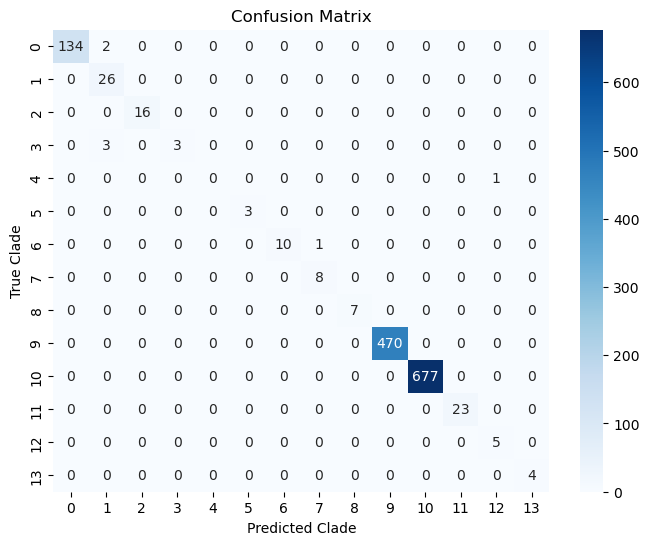

In [109]:
# Confusion Matrix with Seaborn
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true_new, y_pred_new)

# Create a new figure for the confusion matrix
plt.figure(figsize=(8, 6))

# Create heatmap using seaborn
heatmap(cm, annot=True, fmt="d", cmap="Blues") # Customize heatmap with annotations, format, and colormap

# Add labels and title
plt.xlabel("Predicted Clade")
plt.ylabel("True Clade")
plt.title("Confusion Matrix")

# Show the confusion matrix
plt.show()